In [81]:
from omegaconf import OmegaConf
import torch
import matplotlib.pyplot as plt
from torch_geometric.data import Batch
import numpy as np


from models.vae import VanillaVAE
from models.vae import BaseModel as BaseVAE

from models.encoder import BaseModel as EctEncoder

from metrics.metrics import get_mse_metrics
from metrics.accuracies import compute_mse_accuracies
from metrics.loss import compute_mse_loss_fn

from datasets.dsprites import DataModule, DataModuleConfig
from layers.ect import EctLayer, EctConfig
from layers.directions import generate_directions

DEVICE = "cuda:0"
ECT_PLOT_CONFIG = {"cmap":"bone","vmin":-0.5,"vmax":1.5}
PC_PLOT_CONFIG = {"s":10,"c":'.5'}

encoder_config = OmegaConf.load("./configs/config_encoder_dsprites.yaml")
vae_config = OmegaConf.load("./configs/config_vae_dsprites.yaml")

In [82]:
layer = EctLayer(
    EctConfig(
        num_thetas=encoder_config.layer.ect_size,
        bump_steps=encoder_config.layer.ect_size,
        normalized=True,
        device=DEVICE,
    ),
    v=generate_directions(encoder_config.layer.ect_size,encoder_config.layer.dim, DEVICE),
)

dm = DataModule(
    DataModuleConfig(root="./data/dsprites", batch_size=256)
)

vae_model = VanillaVAE(in_channels=vae_config.model.in_channels, latent_dim=vae_config.model.latent_dim,img_size=vae_config.layer.ect_size)

# Load the VAE model
metrics = get_mse_metrics()

vae_litmodel = BaseVAE.load_from_checkpoint(
    f"./trained_models/{vae_config.model.save_name}",
    model=vae_model,
    training_accuracy=metrics[0],
    test_accuracy=metrics[1],
    validation_accuracy=metrics[2],
    accuracies_fn=compute_mse_accuracies,
    loss_fn=compute_mse_loss_fn,
    learning_rate=0.01,
    layer=layer,
).to(DEVICE)


# Load the encoder 

ect_encoder_litmodel = EctEncoder.load_from_checkpoint(
    f"./trained_models/{encoder_config.model.save_name}",
    layer=layer,
    ect_size=encoder_config.layer.ect_size,
    hidden_size=encoder_config.model.hidden_size,
    num_pts=encoder_config.model.num_pts,
    num_dims=encoder_config.model.num_dims,
    learning_rate=encoder_config.model.learning_rate,
).to(DEVICE)

In [83]:

l = dm.val_ds[:].latent.view(-1,6)

y = l[:,1]

idxs = torch.hstack(
    [
        # torch.where(y==1)[0][:1],
        # torch.where(y==2)[0][:1],
        torch.where(y==3)[0][:1],
    ]
)


data_list = []
for idx in idxs:
    data_list.append(dm.val_ds[idx])


batch = Batch.from_data_list(data_list).to(DEVICE)

In [84]:
batch.to(DEVICE)
ect = layer(batch,batch.batch).unsqueeze(1)

print(ect.shape)

ect_batch = []

for idx in range(ect.shape[3]):
    ect_batch.append(torch.roll(ect,idx,3))


ect_batch = torch.stack(ect_batch)


torch.Size([1, 1, 64, 64])


In [85]:

def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)



with torch.no_grad():
    recon_batch = ect_encoder_litmodel.model.forward(ect_batch)

recon_batch.shape

# ect_batch.shape

torch.Size([64, 256])

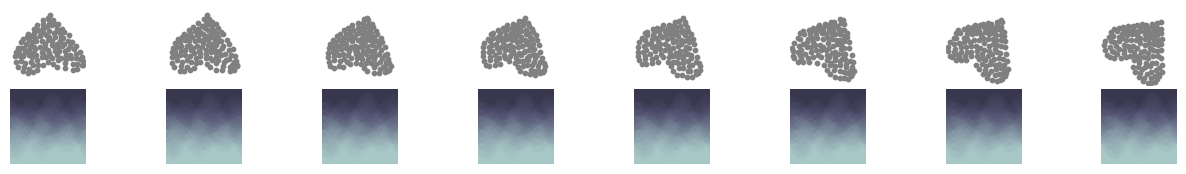

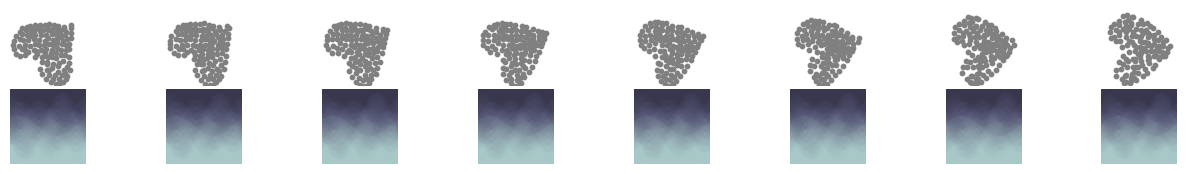

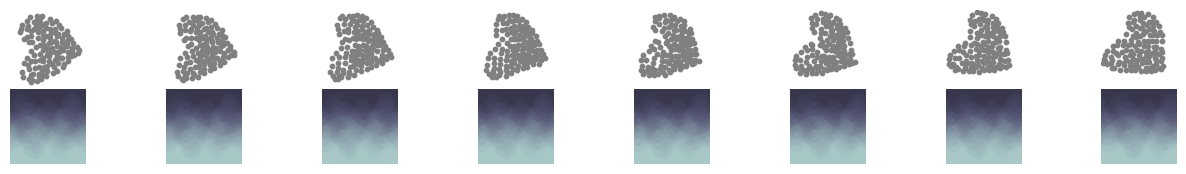

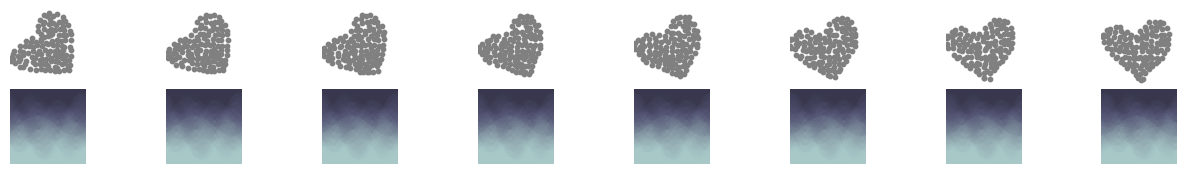

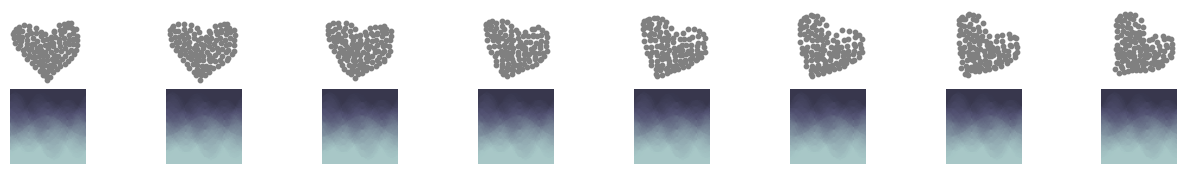

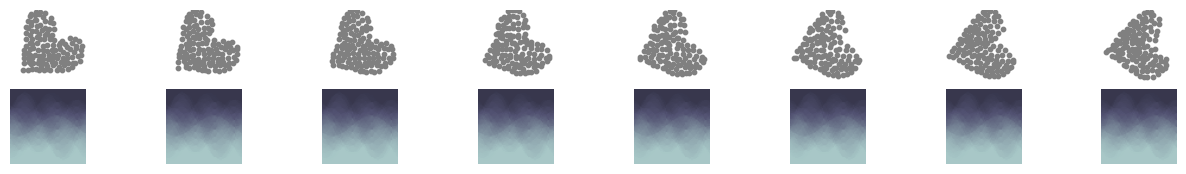

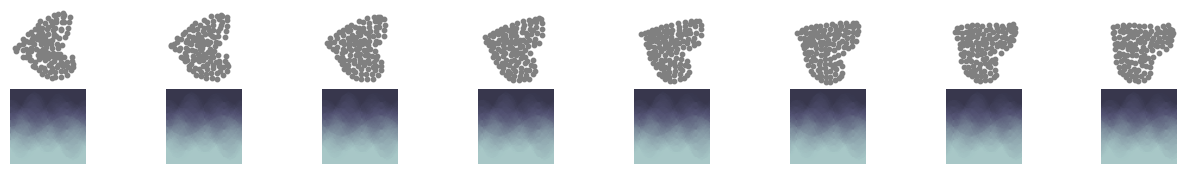

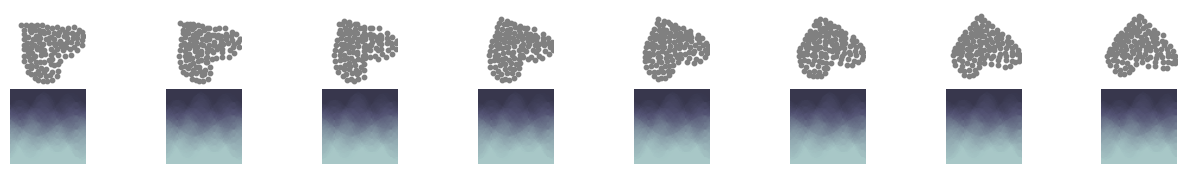

In [86]:

for batch_idx in range(8):
    fig, axes = plt.subplots(
        nrows=2, ncols=8, figsize=(16,2)
    )
    fig.subplots_adjust(wspace=0.05,hspace=0.05)

    for idx, ax in enumerate(axes.T):
        
        # print(recon_pts_x.shape)
        recon_pts = recon_batch[8*batch_idx + idx].view(-1,2).cpu().detach().squeeze().numpy()
        
        recon_pts = rotate(recon_pts, degrees=-90)
        
        ax[0].scatter(recon_pts[:,0],recon_pts[:,1],**PC_PLOT_CONFIG)
        ax[0].set_xlim([-1,1])
        ax[0].set_ylim([-1,1])
        ax[0].set_aspect(1)
        ax[0].axis("off")

        ax[1].imshow(ect_batch[8*batch_idx + idx].cpu().detach().squeeze().numpy(),**ECT_PLOT_CONFIG)
        ax[1].axis("off")
    
# plt.savefig("./figures/img/dsprites/reconstructed_pointcloud.svg",transparent=True)